In [1]:
library(cooccur)
setwd("~/projects/next_gen_attribution/src/analysis/path_analysis/R")

source("~/R_connector/libraries.R")
mozart <- connToEDW(dataBase = "Mozart", connType = 'normal', user = 'pgurican', pass=trimws(read_file("~/R_connector/p.txt")))
hopper <- connToEDW(dataBase = "Hopper", connType = 'normal', user = 'pgurican', pass=trimws(read_file("~/R_connector/p.txt")))

Loading required package: DBI
Loading required package: rJava
------------------------------------------------------------------------------
data.table + dplyr code now lives in dtplyr.
Please library(dtplyr)!
------------------------------------------------------------------------------

Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract


Attaching package: ‘DescTools’

The following object is masked from ‘package:data.table’:

    %like%



In [2]:
lookup <- dbGetQuery(conn = hopper, "select * from P_TRAFFIC_T.MTA_CHANNEL_ANALYSIS_LOOKUP_v2")

In [3]:
channels <- dbGetQuery(conn = hopper, "select * from P_TRAFFIC_T.MTA_CHANNEL_ANALYSIS_v2")

In [4]:
n_sites <- nrow(channels)

In [5]:
sample_sites <- as.list(sample(x = unlist(channels$channels_present), replace = FALSE, size = n_sites))

m <- do.call(rbind, lapply(sample_sites,function(x){ as.integer(intToBits(x))}))
m <- t(m)[1:(log2(max(lookup$mask)) + 1) ,]
rownames(m) <- (lookup %>% arrange(mask))$channel_name

In [6]:
rownames(m)

[1] "organic"                       "site_emails"                  
 [3] "Display"                       "Natural Search"               
 [5] "epn"                           "Paid Search"                  
 [7] "mktng_emails"                  "Unassigned"                   
 [9] "Partner Integration"           "Paid Social"                  
[11] "Social Media"                  "Exclusion"                    
[13] "Partner Integration - Organic" "Affiliate"                    
[15] "Others"                        "Paid Search . Brand"          
[17] "Non-IM Mktg Initiatives"       "Natural Search - Gbase"       
[19] "Programmatic"

In [8]:
# Exclude meaningless channels
excluded_channels <- c("Affiliate", 
                       "Shopping Comparison  - SDC", 
                       "Natural Search - Gbase", 
                       "Others",
                       "Exclusion",
                      "Programmatic",
                      "Non-IM Mktg Initiatives",
                      "Paid Search . Brand",
                      "Non-IM Mktg Initiatives"
                      )
m_excl <- m[!(rownames(m) %in% excluded_channels),]

In [9]:
rownames(m_excl)

[1] "organic"                       "site_emails"                  
 [3] "Display"                       "Natural Search"               
 [5] "epn"                           "Paid Search"                  
 [7] "mktng_emails"                  "Unassigned"                   
 [9] "Partner Integration"           "Paid Social"                  
[11] "Social Media"                  "Partner Integration - Organic"

In [136]:
t1 <- Sys.time()
cooccur_fit <- cooccur(mat = m,
                      type = "spp_site",
                      thresh = FALSE, 
                      spp_names = TRUE)

t2 <- Sys.time()

t2 - t1

  |======================================================================| 100%


Time difference of 10.14565 mins

In [10]:
t1 <- Sys.time()
cooccur_fit_excl <- cooccur(mat = m_excl,
                      type = "spp_site",
                      thresh = FALSE, 
                      spp_names = TRUE)

t2 <- Sys.time()

t2 - t1

  |======================================================================| 100%


Time difference of 54.94732 mins

Saving 6.67 x 6.67 in image


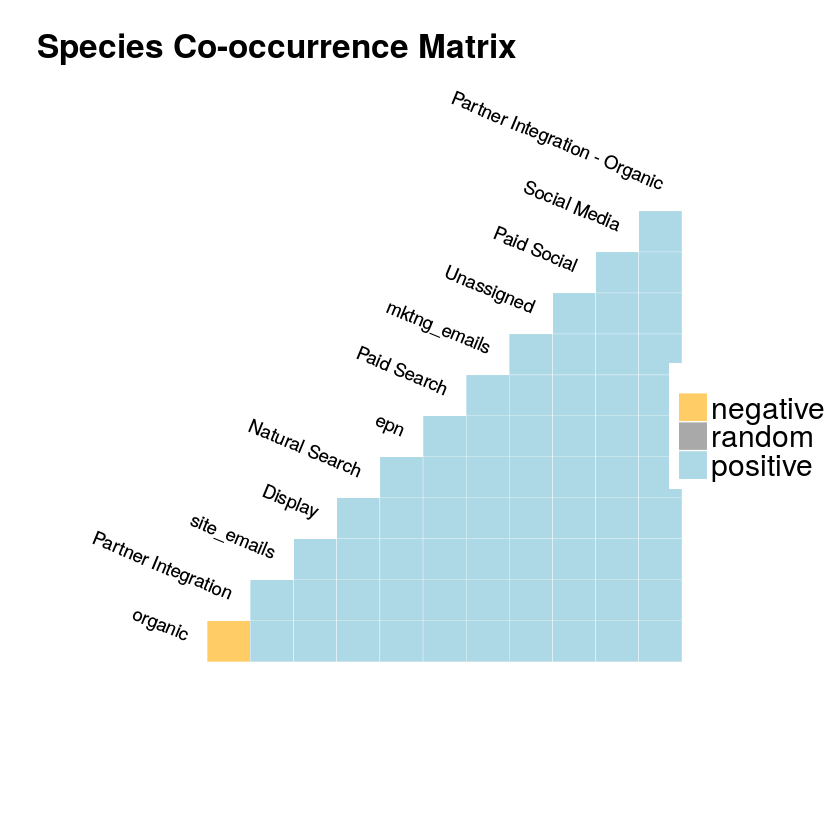

In [11]:
plot(cooccur_fit_excl)
ggsave(paste("figs/channels_coocc_matrix_excl", ".pdf", sep =""))

Saving 6.67 x 6.67 in image


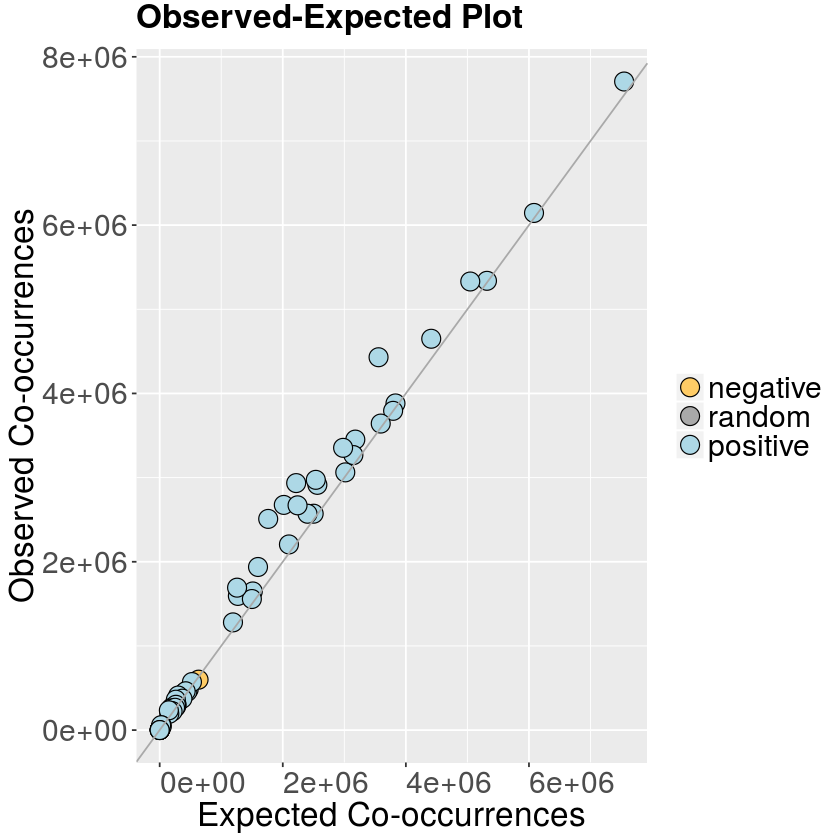

In [16]:
obs.v.exp(cooccur_fit_excl)
ggsave(paste("figs/channels_observed_expected_excl", ".pdf", sep =""))

In [17]:
library(plotly)



Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout



In [18]:
ggplotly()

We recommend that you use the dev version of ggplot2 with `ggplotly()`
Install it with: `devtools::install_github('hadley/ggplot2')`


HTML widgets cannot be represented in plain text (need html)

## Own implementation of the co-occurrence function (incl. lift)

In [13]:
hypergeom_cooccurence <- function(m){

    allPairs <- combn(1:nrow(m), 2)

    all_pairs_pvalues <- do.call(rbind, apply(allPairs, MARGIN = 2, function(x) {
        warn <- FALSE
        t <- table(m[x[1],], m[x[2], ])
        obs <- t[2,2]
        N1 <- t[2,1] + t[2,2]
        N2 <- t[1,2] + t[2,2]
        N <- sum(t)
        exp <- as.numeric(N1)*as.numeric(N2)/as.numeric(N)

        data.frame(channel_1 = as.factor(rownames(m)[x[1]]),
                   channel_2 = as.factor(rownames(m)[x[2]]),
                   p_value_chisq = tryCatch({round(chisq.test(t)$p.value, 5)},
                                     warning = function(w) {warn <- TRUE}),
                   unstable_pvalue = warn,
                   incidence_1 = N1,
                   incidence_2 = N2,
                   observed_pairs = obs,
                   expected_pairs = exp,
                   lift = round((obs-exp)/exp, 5),
                   observed_p = round(obs/N, 5),
                   p_lt = round(phyper(obs, N2, N-N2, N1), 5), 
                   p_gt = round(dhyper(obs, N2, N-N2, N1) + phyper(obs, N2, N-N2, N1, lower.tail = FALSE), 5))
    }))
    
    return(all_pairs_pvalues)
}

In [391]:
hypergeom_cooccur_fit <- hypergeom_cooccurence(m)

In [344]:
hypergeom_cooccur_fit %>% arrange(desc(lift)) %>% filter(observed_pairs > 10000)

channel_1,channel_2,p_value_chisq,unstable_pvalue,incidence_1,incidence_2,observed_pairs,expected_pairs,lift,observed_p,p_lt,p_gt
epn,Social Media,0e+00,FALSE,1480625,271998,123271,66241.68,0.86093,0.02028,1.00000,0e+00
Natural Search,Social Media,0e+00,FALSE,2643601,271998,191603,118272.07,0.62002,0.03152,1.00000,0e+00
Natural Search,Paid Search,0e+00,FALSE,2643601,1840925,1203786,800483.84,0.50382,0.19800,1.00000,0e+00
Natural Search,epn,0e+00,FALSE,2643601,1480625,910874,643815.68,0.41481,0.14982,1.00000,0e+00
Paid Search,epn,0e+00,FALSE,1840925,1480625,618540,448334.06,0.37964,0.10174,1.00000,0e+00
Unassigned,Social Media,0e+00,FALSE,3315785,271998,197815,148344.91,0.33348,0.03254,1.00000,0e+00
Paid Search,Partner Integration,0e+00,FALSE,1840925,287906,110329,87178.10,0.26556,0.01815,1.00000,0e+00
Unassigned,Natural Search,0e+00,FALSE,3315785,2643601,1807901,1441792.74,0.25393,0.29737,1.00000,0e+00
Paid Search,Social Media,0e+00,FALSE,1840925,271998,102836,82361.14,0.24860,0.01691,1.00000,0e+00
Unassigned,epn,0e+00,FALSE,3315785,1480625,1007501,807517.62,0.24765,0.16572,1.00000,0e+00


### Cooccurence with lift and unimportant channels excluded

In [14]:
hypergeom_cooccur_fit_excl <- hypergeom_cooccurence(m_excl)

Saving 6.67 x 6.67 in image


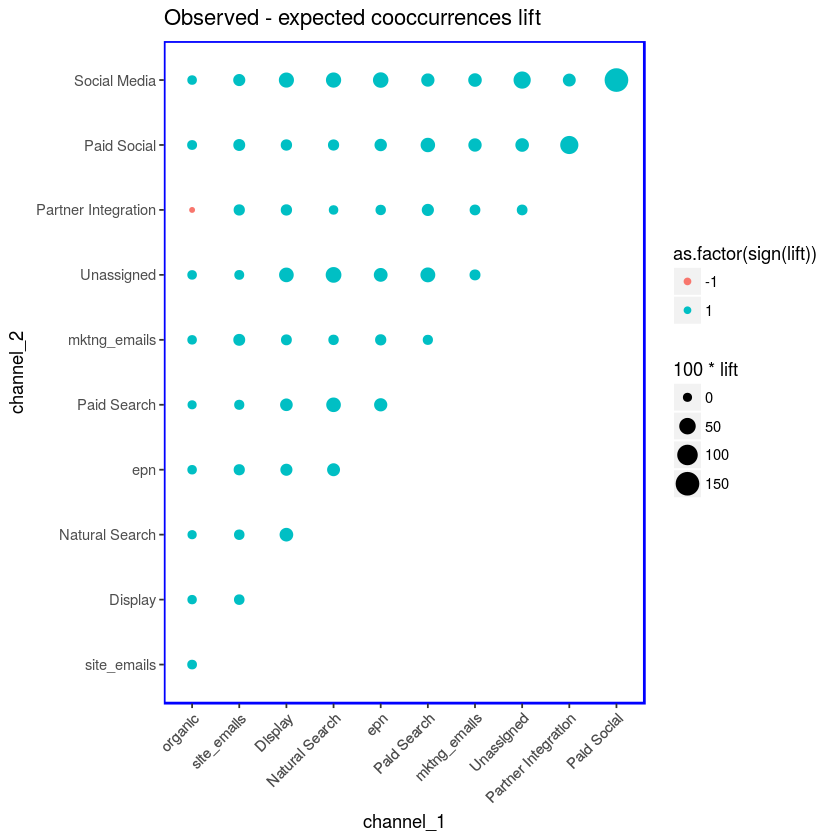

In [22]:
library(ggplot2)
ggplot(data = hypergeom_cooccur_fit_excl %>% filter(observed_pairs > 10000), # %>%
                #filter(as.character(channel_1) <= as.character(channel_2)),
       aes(x=channel_1, 
           y=channel_2)) + 
  geom_point(aes(size = 100*lift, color = as.factor(sign(lift)))) +
  #scale_fill_manual(values=c("-1" = "#c62828", "1"="#2E7D32")) +
  theme(panel.background=element_blank(),
        panel.border = element_rect(colour = "blue", fill=NA, size=1),
        axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
  ggtitle("Observed - expected cooccurrences lift")
ggsave(paste("figs/cooccurrence_lift_excl", ".pdf", sep =""))

## (Attempt at) network visualizations - to be continued...

In [138]:
cooccur_links <- data.frame(source = cooccur_fit$results$sp1_name, 
                              target = cooccur_fit$results$sp2_name, 
                              value = cooccur_fit$results$prob_cooccur) %>% 
                    arrange(source)

In [143]:
cooccur_nodes <- data.frame(name = union(unique(cooccur_links$source),
                                         unique(cooccur_links$target)),
                            group = 1) %>% arrange(name)

In [152]:
node_codes <- cbind(levels(cooccur_nodes$name), 0:(nrow(cooccur_nodes) - 1))

In [153]:
node_encoder <- function(x){node_codes[node_codes[,1] == x, 2]}

In [156]:
cooccur_links_trans <- data.frame(
            source = unlist(lapply(cooccur_links$source, node_encoder)),
            target = unlist(lapply(cooccur_links$target, node_encoder)), 
            value = cooccur_links$value)


In [146]:
library(networkD3)

In [186]:
force_graph <- forceNetwork(Links = cooccur_links_trans,
                            Nodes = cooccur_nodes,
                            Source = "source", 
                            Target = "target",
                            Value = "value", 
                            NodeID = "name",
                            linkWidth = JS("function(d) {return 5*Math.sqrt(d.value)}"),
                            radiusCalculation = JS("return 100"),
                            Group = "group", 
                            width = 400, 
                            height = 300,
                            opacity = 0.9,
                            zoom = TRUE,
                            bounded = TRUE
                           )

In [165]:
?forceNetwork

In [187]:
force_graph

HTML widgets cannot be represented in plain text (need html)

In [118]:
cooccur_results$channel_2 <- factor(cooccur_results$channel_2, 
                                    levels = levels(cooccur_results$channel_1))
    

In [120]:
cooccur_effects <- cooccur(mat = m, 
        type = "spp_site", 
        thresh = FALSE,
        spp_names = TRUE, 
        only_effects = TRUE, 
        eff_standard = TRUE,
        eff_matrix = TRUE)

  |======================================================================| 100%


In [189]:
class(cooccur_effects)

[1] "dist"

In [211]:
cooccur_effects_mat <- as.matrix(cooccur_effects)
xy <- t(combn(colnames(cooccur_effects_mat), 2))
f <- data.frame(xy, dist = cooccur_effects_mat[xy])
colnames(f) <- c("Channel1", "Channel2", "dist")

f[f[,3] == 0, 3] <- NA
f %<>% filter(!is.na(dist)) %>% arrange(Channel1)

effects_nodes <- data.frame(name = union(unique(f$Channel1),
                                         unique(f$Channel2)),
                            group = 1) %>% arrange(name)

effects_node_codes <- cbind(levels(effects_nodes$name), 0:(nrow(effects_nodes) - 1))
effects_node_encoder <- function(x){effects_node_codes[effects_node_codes[,1] == x, 2]}

effects_links <- data.frame(
            source = unlist(lapply(f$Channel1, node_encoder)),
            target = unlist(lapply(f$Channel2, node_encoder)), 
            value = f$dist)

In [217]:
forceNetwork(Links = effects_links,
                            Nodes = effects_nodes,
                            Source = "source", 
                            Target = "target",
                            Value = "value", 
                            NodeID = "name",
                            linkWidth = JS("function(d) {return 100*d.value}"),
                            radiusCalculation = JS("return 100"),
                            Group = "group", 
                            width = 400, 
                            height = 300,
                            opacity = 0.9,
                            zoom = TRUE,
                            bounded = TRUE
                           )

HTML widgets cannot be represented in plain text (need html)

In [132]:
library(qgraph)

In [ ]:
dist_mi <- 1/dist_m # one over, as qgraph takes similarity matrices as input
library(qgraph)

In [ ]:
pdf('figs/example_qplot.pdf', width=1000, height=1000, unit='px')

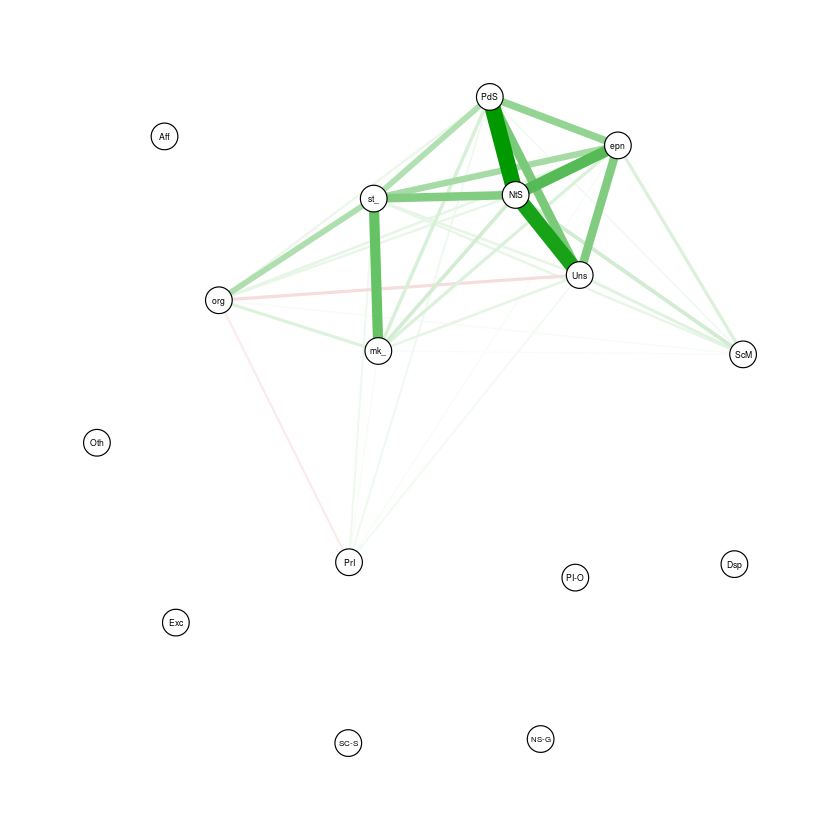

In [134]:
qgraph(cooccur_effects_mat * 100, layout='spring', vsize=3)

In [135]:
library(d3Network)

In [ ]:
dev.off()